In [1]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import numpy as np

transform_pipeline = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [47]:

def load_model(checkpoint_path):
    model = models.resnet18(pretrained=False)  # Example model, change according to your needs
    # model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    return model

def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    # random image tensor
    image = torch.rand(3, 256, 256)
    return transform_pipeline(image).unsqueeze(0)

def process_activation(model, input_tensor, target_layer, iterations=30, lr=1.0):
    layer_output = {}

    def hook(module, input, output):
        layer_output[target_layer] = output

    handle = getattr(model, target_layer).register_forward_hook(hook)
    input_tensor.requires_grad = True

    for i in range(iterations):
        model.zero_grad()
        _ = model(input_tensor)
        activation = layer_output[target_layer].mean()
        activation.backward()
        input_tensor.data += lr * input_tensor.grad.data
        input_tensor.grad.zero_()

    handle.remove()
    return input_tensor.detach()

def deprocess_image(tensor):
    tensor = tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    tensor = tensor.clamp(0, 1)
    tensor = tensor.numpy().transpose(1, 2, 0)
    return (tensor * 255).astype(np.uint8)

def activation_maximization(checkpoint_path, image_path, target_layer):
    model = load_model(checkpoint_path)
    input_tensor = load_image(image_path)
    optimized_tensor = process_activation(model, input_tensor, target_layer)
    return deprocess_image(optimized_tensor)


In [48]:
# for usage
checkpoint_path = 'trained_models/ResNet18_MNIST.pth'
image_path = ''
target_layer = 2
resulting_image = activation_maximization(checkpoint_path, image_path, target_layer)

/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


AttributeError: 'str' object has no attribute 'read'

In [36]:
# generating synthetic dataset using activation maximization for each output class of the given model

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
from PIL import Image

from models import load_model
from utils import load_config
import matplotlib.pyplot as plt


class SyntheticGenerator():
    def __init__(self, pretrained_model, data_config, device, logger, size_per_class, iterations=1000):

        self.model = pretrained_model
        self.size = size_per_class
        self.device = device
        
        self.logger = logger
        self.iterations = iterations
        self.data_config = data_config

        print(self.data_config["input_shape"])
        self.transform = transforms.Compose([
            transforms.Resize(self.data_config["input_shape"][1:]),
            transforms.ToTensor()
        ])

        self.model.eval()
        self.model.to(self.device)
        """ convert the activation function of the final layer of the model from softmax to linear """
        



    def generate_dataset(self,  batch_size = 64,output_dir = None):

        data = []
        data_labels = []
        dataloader = None

        for _ in range(self.size):
            for label in range(self.data_config["num_classes"]):

                gen_img = self.generate_batch(label, batch_size)
                data.append(gen_img)
                data_labels.append(label)

        # data = torch.stack(data) 
        # change the shape of the data from labels x batch x img_shape  to
        data_labels = torch.tensor(data_labels)

        dataloader = DataLoader(TensorDataset(data, data_labels), batch_size= batch_size, shuffle=True)

        if output_dir:
            print("Saving dataset to ", output_dir)
            torch.save(dataloader, output_dir)

        return dataloader


    def generate_batch(self, label, batch_size):

        image = self.random_image(batch_size).to(self.device)
        image.requires_grad = True

        optimizer = optim.Adam([image], lr=0.01)

        for _ in range(self.iterations):

            optimizer.zero_grad()
            output = self.model(image)
            loss = -output[0][label]
            loss.backward()
            optimizer.step()

        return image


    def random_image(self, batch_size = 64):

        random_high, random_low = 180, 160

        mean=torch.tensor([0.485]).unsqueeze(0).unsqueeze(2).unsqueeze(3)
        std=torch.tensor([0.229]).unsqueeze(0).unsqueeze(2).unsqueeze(3)

        random_high, random_low = 180, 160

        random_image = torch.rand(batch_size, *self.data_config["input_shape"])

        print(f"the shape of the generated image is {random_image.shape}")
        
        random_image = (((random_high - random_low) * random_image + random_low)/255)
        random_image = (random_image - mean) / std


        return random_image

def visualize_image(input_image: torch.Tensor):
    """given a torch tensor of shape [1, 28, 28] visualize an image of the MNIST dataset"""

    input_image = input_image.cpu().detach().numpy().squeeze()
    plt.imshow(input_image, cmap='gray')
    plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from models import load_model
from utils import load_config

class SyntheticGenerator():
    def __init__(self, pretrained_model, data_config, device, logger, size_per_class, iterations=1000):
        self.model = pretrained_model
        self.size = size_per_class
        self.device = device
        self.logger = logger
        self.iterations = iterations
        self.data_config = data_config

        self.model.eval()
        self.model.to(self.device)

        # Transformations, if necessary, adjust according to actual need
        self.transform = transforms.Compose([
            transforms.Resize(self.data_config["input_shape"][1:]),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229])  # Adjust as per actual dataset mean/std
        ])

    def generate_dataset(self, batch_size=64, output_dir=None):
        data = []
        data_labels = []

        for label in range(self.data_config["num_classes"]):
            for _ in range(self.size):
                gen_img = self.generate_batch(label, batch_size)
                data.append(gen_img)
                data_labels.append(torch.full((batch_size,), label, dtype=torch.long))

        data = torch.cat(data)
        data_labels = torch.cat(data_labels)

        dataloader = DataLoader(TensorDataset(data, data_labels), batch_size=batch_size, shuffle=True)

        if output_dir:
            print("Saving dataset to ", output_dir)
            torch.save(dataloader, output_dir)

        return dataloader

    def generate_batch(self, label, batch_size):
        image = self.random_image(batch_size).to(self.device)
        image.requires_grad = True
        optimizer = optim.Adam([image], lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

        for _ in range(self.iterations):
            optimizer.zero_grad()
            output = self.model(image)
            class_loss = -output[:, label].sum()

            # Regularization terms
            l2_loss = 0.001 * torch.norm(image)
            tv_loss = 0.001 * (torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) +
                               torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :])))
            
            loss = class_loss + l2_loss + tv_loss
            loss.backward()
            optimizer.step()
            scheduler.step()

            with torch.no_grad():
                image.clamp_(0, 1)  # Keep image values within valid range

        return image.detach()

    def random_image(self, batch_size=64):
        # Initialize close to the dataset mean
        random_image = torch.rand(batch_size, *self.data_config["input_shape"], device=self.device)
        random_image = random_image * 0.5 + 0.5  # Rescale to [0.5, 1.0]
        return random_image

def visualize_image(input_image: torch.Tensor):
    input_image = input_image.cpu().detach().numpy().squeeze()
    plt.imshow(input_image, cmap='gray')
    plt.show()




In [3]:

config_dir = "configs/model_configs/ResNet18_MNIST.yaml"
model_config = load_config(config_dir)
model, trained = load_model(model_config, torch.device("cuda"))

if not trained:
    raise ValueError("Model must be trained.")

dataset_dir = "configs/dataset_configs/MNIST.yaml"
data_config = load_config(dataset_dir)

device = torch.device("cuda")
logger = None
size_per_class = 1

generator = SyntheticGenerator(model, data_config, device, logger, size_per_class)

print("model loaded")



/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bini/anaconda3/envs/augcon/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model build as resnet18, pretrained: True, output channels: 10
Loading model from ./trained_models/ResNet18_MNIST.pth
Model loaded from ./trained_models/ResNet18_MNIST.pth
model loaded


In [5]:
sample_dataloader = generator.generate_dataset()



In [10]:
from train import test_model
from utils import get_logger

logger = get_logger("logs/")

test_model(model, sample_dataloader, device, logger, model_config)


Started testing


Accuracy of the network on the test images: 99.38%


Finished testing



99.375

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 0


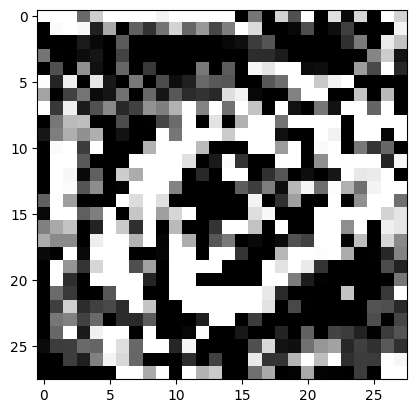

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 0


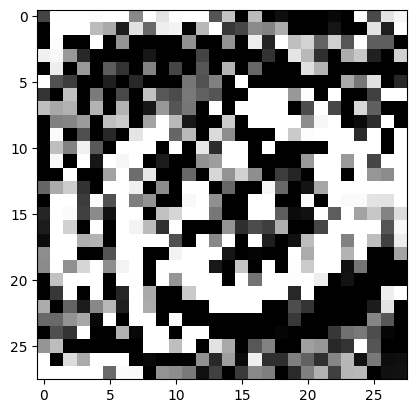

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 2


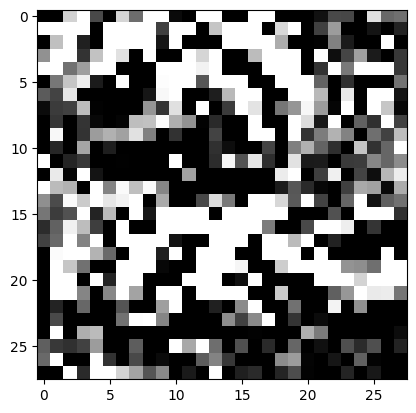

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 5


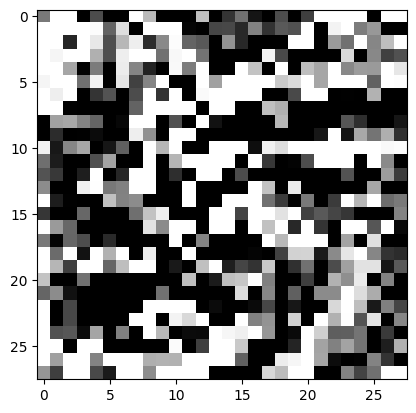

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 1


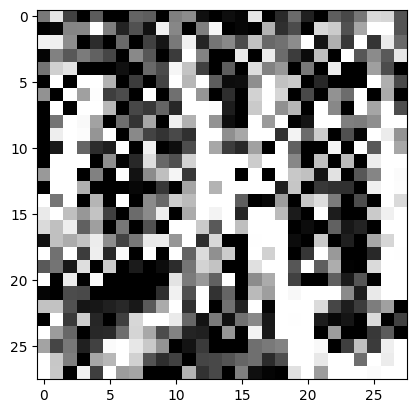

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 9


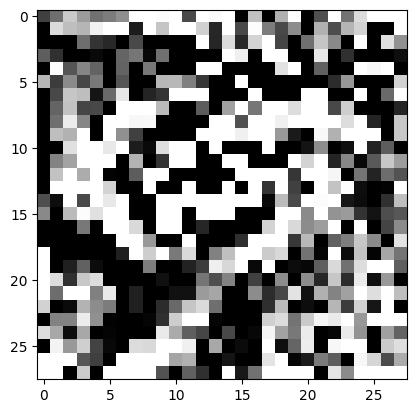

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 5


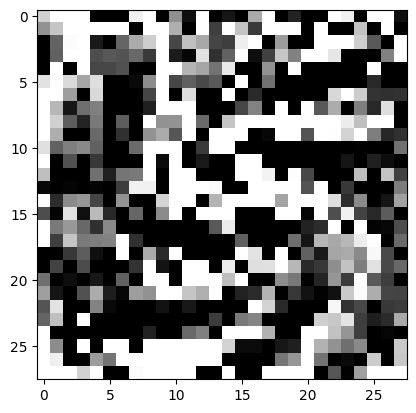

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 1


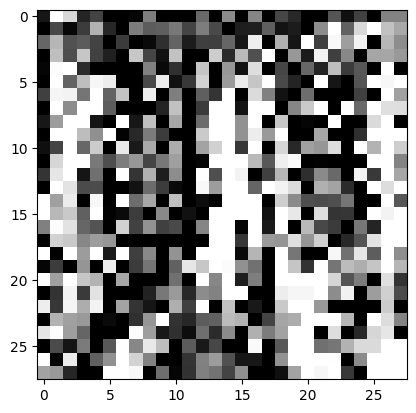

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 0


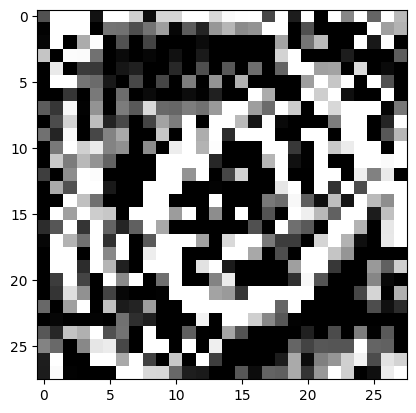

torch.Size([64, 1, 28, 28])
torch.Size([64])
the label is 3


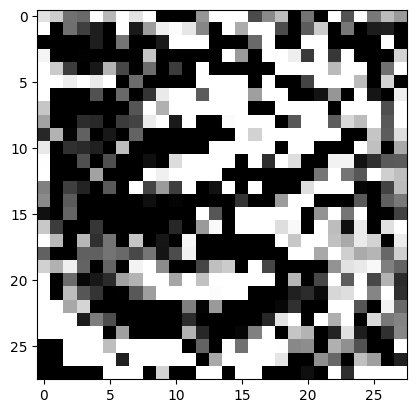

In [6]:

for i, (batch_data, batch_label) in enumerate(sample_dataloader):

    print(batch_data.shape), print(batch_label.shape)

    rand_idx = 2
    print(f"the label is {batch_label[rand_idx]}")
    visualize_image(batch_data[rand_idx])

    
# data_l = data_l.unsqueeze(0)
# output = model(data_l)
# data_l.shape, print(output), output.shape
    

In [65]:
from train import test_model
from utils import get_logger

logger = get_logger("logs")

def unpack_dataloader(data_loader):
    """change the shape of the data loader from 10 x 64 x img_shape to 640 x img_shape"""
    "return data loader"

    data = []
    labels = []

    for i, (d, l) in enumerate(data_loader):

        data.append(d)
        labels.append(l)

    """ change data from List of tensors to a single tensor that is the concatenation of the tensors"""


    data = torch.cat(data)
    data = data.view(-1, *data.shape[2:])

    print(data.shape)

    
    labels = torch.cat(labels)
    # convert each value of labels to 64 values

    labels = labels.repeat(64)
    print(labels.shape)
    

    return DataLoader(TensorDataset(data, labels), batch_size=64, shuffle=True)

sample_dataset = unpack_dataloader(sample_dataloader)
test_model(generator.model, sample_dataset, device, logger, model_config)

torch.Size([640, 28, 28])
torch.Size([40960])


AssertionError: Size mismatch between tensors

In [12]:
# res18mnist, trained =
# import os
# print(os.path.curdir)
model_config_dir = "configs/model_configs/ResNet18_MNIST.yaml"
model_config1 = load_config(model_config_dir)


image1 = torch.rand(32, 1, 28, 28)
# image1.shape
model1, t = load_model(model_config1, torch.device("cuda"))

model1(image1)

# trained

Model build as resnet18, pretrained: True, output channels: 10
Loading model from ./trained_models/ResNet18_MNIST.pth
Model loaded from ./trained_models/ResNet18_MNIST.pth


tensor([[ -1.0759,  -1.0002,   1.7754,   0.9550,  -3.2916,  -0.9564,  -3.4592,
           2.7722,  -0.1488,  -1.5632],
        [ -1.3871,  -2.2722,   0.2847,   0.4635,  -2.3006,  -2.1271,  -6.4316,
           5.0379,  -3.9110,   2.2982],
        [ -0.8139,  -1.3918,  -2.4930,  -1.0181,  -0.9492,   4.7967,   0.4596,
          -1.5574,  -1.2047,  -1.6944],
        [  1.4160,  -2.3102,   2.1292,  -1.3787,  -0.1696,  -2.1457,  -3.4218,
           2.4685,  -2.2912,  -0.0589],
        [  3.6905,   0.8090,   2.1424,  -1.3780,  -2.7229,  -2.9627,  -1.9441,
          -0.3368,   0.0678,  -2.8549],
        [ -0.9086,   2.0907,   3.5047,  -0.7963,   0.3548,  -3.3587,  -1.2824,
           0.3582,  -2.2192,  -2.9956],
        [ -2.8173,  -1.8814,  -5.3222,  -4.1239,   1.0306,   5.2410,   6.5485,
          -7.3088,  -1.5296,  -0.4710],
        [ -0.3334,   0.4692,   2.0075,   0.9493,  -2.0263,  -1.9701,  -1.5203,
           0.5659,  -1.3945,  -2.2239],
        [ -0.8927,   2.7841,  -3.3150,  -4.9243,

In [9]:

shape1 = [64,3,128,128]

torch.rand(1, *shape1).shape

torch.Size([1, 64, 3, 128, 128])